### Facial Expression

In this notebook we are going to use the [MMA FACIAL EXPRESSION](https://www.kaggle.com/mahmoudima/mma-facial-expression) dataset from kaggle to create a Nueral Network that classifies facial expression from an image of a face. 

Our Nueral Network Model will classifiy `7` facial expression:

1. `angry`
2. `disgust`
3. `fear`
4. `happy`
5. `neutral`
6. `sad`
7. `surprise`

```py
[angry, disgust, fear, happy, neutral, sad, surprise]
```

### Dataset 

We will need to download the data using the `kaggle` API and we will create a dataset from it using the `ImageFolder` from pytorch. The folders will be looking as follows:

```
📁 MMAFEDB
  📁 train
    📁 angry
    📁 disgust
    📁 fear
    📁 happy
    📁 neutral
    📁 sad
    📁 surprise
  📁 test
  📁 valid
```

### Setting up the environment for kaggle

1. First, we need to have a Kaggle account in order to generate an API key. Once we're logged on to Kaggle, we need to go to:

1. https://www.kaggle.com/account
2. Click Generate New API Token which will download a `kaggle.json` file.
3. Place this at `~/.kaggle/kaggle.json` (or, if you're on Windows, at `C:\Users\<Windows-username>\.kaggle\kaggle.json`).
4. If we are using Google Colab, an alternative is simply set the environment variables `KAGGLE_USERNAME` and `KAGGLE_KEY` to their respective values. This is what we do below.

> Note that the `KAGGLE_USERNAME` and `KAGGLE_KEY` will be found in the `kaggle.json` file when click `Generate New API`

In [2]:
import os

In [3]:
os.environ["KAGGLE_USERNAME"] = "garidziracrispen"
os.environ['KAGGLE_KEY'] = "6deb26301cd6d395bd0c07861b7715d2"

In [4]:
!pip install kaggle
!kaggle datasets download mahmoudima/mma-facial-expression --unzip

 88% 146M/166M [00:01<00:00, 109MB/s]
100% 166M/166M [00:01<00:00, 137MB/s]


### Basic imports
In the following code cell we are going to import the basic imports that we are going to use throughout this notebook.

In [5]:
import torch, random
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt

import os
import time
from prettytable import PrettyTable

torch.__version__

'1.10.0+cu111'

### Seeds
In the following code cell we are then going to set up the `SEED` for reproducivity.

In [6]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
Get `GPU` acelleration if possible

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Paths

In [8]:
base_path = "/content/MMAFEDB"

### Image Transformations

We are going to load the images using the `datasets.ImageFolder` from `torchvision` so we need to define some transformation on our images for each set. The following transforms are going to be applied to our images in sequence using the `transforms.Compose`

1. train
* Resize (IMG_SIZE, IMG_SIZE)
* RandomRotation()
* RandomHorizontalFlip()
* RandomCrop(IMG_SIZE)
* ToTensor()
* Normalize() with meand and std = `.5`

2, 3. test/validation

* Resize (IMG_SIZE, IMG_SIZE)
* ToTensor()
* Normalize() with meand and std = `.5`


```
IMG_SIZE=224
```

In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
IMG_SIZE=224

In [50]:
image_transforms = {
    "train": transforms.Compose([
       transforms.Resize(IMG_SIZE),
       transforms.RandomRotation(5),
       transforms.RandomHorizontalFlip(.5),
       transforms.RandomCrop(IMG_SIZE, padding=2),
       transforms.ToTensor(),
       transforms.Normalize(mean=mean, std=std, inplace=False)                         
    ]),
    "valid": transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std, inplace=False)
    ]),
    "test": transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std, inplace=False)
    ])
}

### Creating a dataset

We are then going to create an `image_dataset` with three sets `train`, `test` and `valid` sets.

In [51]:
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(base_path, x),
        transform = image_transforms[x]
    ) for x in os.listdir(base_path)
}

### Class names

We are going to get all the classnames that we are going to have in this dataset in the following code cells.

In [52]:
class_names = image_datasets["train"].classes
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

### Visualizing examples 

We are then going to count how many examples do we have in our dataset

In [53]:
def tabulate(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

In [54]:
train_data = image_datasets["train"]
val_data = image_datasets["valid"]
test_data = image_datasets["test"]

In [55]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = ("train", len(train_data)), ("test", len(test_data)), ("val", len(val_data))
tabulate(columns, data_rows, title)


+-------------------+
| DATASETS EXAMPLES |
+---------+---------+
| SET     |   TOTAL |
+---------+---------+
| train   |   92968 |
| test    |   17356 |
| val     |   17356 |
+---------+---------+


### Visulizing images

The following helper function will take in images and lables and visualize them

In [56]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

In [57]:
def plot_images(images, labels, classes, normalize = True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (10, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
        image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.axis('off')

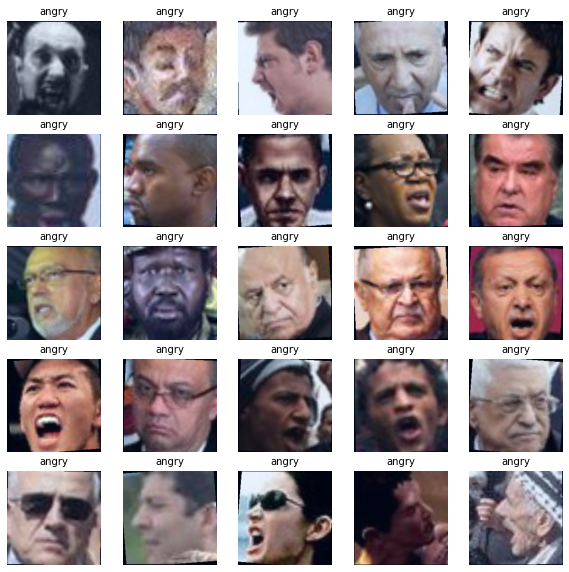

In [58]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

### Creating iterators

We are going to create 3 iterators for all our `3` sets with a batch size of `64`

In [59]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE
                                 )
valid_iterator = data.DataLoader(val_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE
                                 )
test_iterator = data.DataLoader(test_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE
                                 )

### VGG model

In the following code cell we are going to build the base achitecture of the `VGG` model.

The base achitecture will takes in `features` and `output_dim`


1. `output_dim` will be the number of classes.
2. `features` it will be an `nn.Sequential` module configured using the  `VGG16` configuration.

In [20]:
class VGG(nn.Module):
  def __init__(self, features, output_dim):
    super().__init__()
    self.features = features
    self.avgpool = nn.AdaptiveAvgPool2d(7)

    self.classifier = nn.Sequential(
      nn.Linear(512 * 7 * 7, 4096),
      nn.ReLU(inplace = True),
      nn.Dropout(0.5),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace = True),
      nn.Dropout(0.5),
      nn.Linear(4096, output_dim)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h

### VGG Configurations

Typically the VGG configurations are defined as lists. Each item in the list is either `'M'`, which denotes a max pooling layer, or an integer, which denotes a convolutional layer with that many filters.

Below are the configurations for `VGG11`, `VGG13`, `VGG16` and `VGG19` also known as configurations `"A"`, `"B"`, `"D"` and `"E"`, respectively.

```py
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
                512, 512, 512, 512, 'M']
```

In our case we are going to use the `vgg16_config`

In [21]:
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

Next we are going to define a function called `get_vgg_layers` which takes in a config and return `nn.Sequential` of layers .

In [22]:
def get_vgg_layers(config, batch_norm):
  layers = []
  in_channels = 3
  for c in config:
    assert c == 'M' or isinstance(c, int)
    if c == 'M':
      layers += [nn.MaxPool2d(kernel_size = 2)]
    else:
      conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
      if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
      else:
          layers += [conv2d, nn.ReLU(inplace = True)]
      in_channels = c   
  return nn.Sequential(*layers)

### VGG16 Sequential of features

In [23]:
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm = True)
print(vgg16_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

### Instance of a model

Now we can create an instance of a `vgg16` model in the following code cell by passing in the configuration and the output dim as follows:

In [25]:
OUTPUT_DIM = len(class_names)
model = VGG(vgg16_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Transfare leaning

We are going to use transfare learning and fine tuning on the `VGG16` model. So the following code cell download the pretrained `VGG16` model.

In [26]:
from torchvision import models
pretrained_model = models.vgg16_bn(pretrained = True)
pretrained_model

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

The `VGG16` models was created to do image classification for `1000` classes. In our case we only have `7` emotions that we want to classify so we are going to use what we call `fine-tuning` and change the last layer of the classifier of `VGG16`.

> _Note that we don't need to the whole model from scratch therefore we may need to freeze some of the layers latter on_.

### Counting parameters of the `VGG16` model

The original `VGG16` model has `138,365,992` trainable parameters. So we want to freeze all the trainable parameters of the model except for our last custom layer.

In [27]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  tabulate(["","Parameters"], 
           [["total parameters", f'{total_params:,}'],
            ["trainable parameters", f'{trainable_params:,}']],
           "MODEL PARAMETERS"
           )
count_params(pretrained_model)

+------------------------------------+
|          MODEL PARAMETERS          |
+----------------------+-------------+
|                      |  Parameters |
+----------------------+-------------+
| total parameters     | 138,365,992 |
| trainable parameters | 138,365,992 |
+----------------------+-------------+


### Checking the classifier layer of `VGG16` model

In [28]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

> We need to change the classifir to have output features of `7` instead of `1000` because our task is to classify 7 emotions.

In [29]:
IN_FEATURES = pretrained_model.classifier[-1].in_features
IN_FEATURES

4096

In [30]:
OUTPUT_DIM  = len(class_names)
final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
final_fc

Linear(in_features=4096, out_features=7, bias=True)

Changing the last layer of the classifier.

In [31]:
pretrained_model.classifier[-1] = final_fc

In [32]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=7, bias=True)
)


### Overiding weights of our `model` with `pretrained_weights` weights



In [33]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [34]:
count_params(model)

+------------------------------------+
|          MODEL PARAMETERS          |
+----------------------+-------------+
|                      |  Parameters |
+----------------------+-------------+
| total parameters     | 134,297,671 |
| trainable parameters | 134,297,671 |
+----------------------+-------------+


### Freezing the parameters of the pretrained model.

In the following code cell we are going to freeze all the trainable parameters of the pretrained vgg16 except for the last layer.

In [35]:
# Frezing the features
for parameter in model.features.parameters():
    parameter.requires_grad = False

# Freezing the pooling layer
model.avgpool.requires_grad = False

# Freezing the classifier except for the last layer
for parameter in model.classifier[:-1].parameters():
    parameter.requires_grad = False

### Counting the parameters after freezing the model.

In [36]:
count_params(model)

+------------------------------------+
|          MODEL PARAMETERS          |
+----------------------+-------------+
|                      |  Parameters |
+----------------------+-------------+
| total parameters     | 134,297,671 |
| trainable parameters |      28,679 |
+----------------------+-------------+


### Training the model
Now it's time to train our model

### Optimizer and Criterion

For the optimizer we are gong to use the `Adam` optimizer with default parameters. And for the `criterion` we are going to use the `CrossEntropyLoss` since this is a multi-label classification task

In [38]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

### Accuracy function

Since this is a multi-label classification we are going to calculate the categorical accuracy of predicted labels againist actual labels.

In [39]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/ y.shape[0]
  return acc

### Training and evaluation functions

In the following code cell we are going to create a `train` and `evaluate` function. 

1. train

* We are going to put the model into train mode using the `model.train()` function
* We iterate over the iterator and put labels and features to the `device`
* restore the opimizer gradients by calling the `optimizer.zero_grad()`
* we will make predictions and calculate the loss and accuracy
* We will then backpropagate using the `loss.backward()` function
* For each and every epoch we are going to return the total loss and accuracy of that epoch.

2. evaluate

* We are going to put the model into eval mode using the `model.eval()` function
* We will wrap our train iterator with the `torch.no_grad()` function since we don't want to calculate gradients during evaluation
* We iterate over the iterator and put labels and features to the `device`
* we will make predictions and calculate the loss and accuracy
* For each and every epoch we are going to return the total loss and accuracy of that epoch.

In [45]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    y_pred, _ = model(x)
    # Calculate the loss and accuracy
    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()

    epoch_loss +=loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### The training loop

We are going to create helper functions that will help us to visualize the training in a well presentable manner

1. function that converts time to string time



In [41]:
def hms_string(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60 * 60)) / 60)
  s = sec_elapsed % 60
  return "{}:{:>02}:{:>05.2f}".format(h, m, s)

2. A function that tabulates training

In [42]:
def tabulate_training(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  table.align[column_names[2]] = 'r'
  table.align[column_names[3]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

### Training loop

We will run the training for `10` epochs and at each and every epoch we are going to save the model when the previous validation loss becomes greater that the current validation loss.

In [61]:
EPOCHS = 5
MODEL_NAME = "facial-emotion-classifier.pt"
best_valid_loss = float('inf')
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  title = f"EPOCH {epoch+1:02}/{EPOCHS} (not saved)"
  if valid_loss < best_valid_loss:
    title = f"EPOCH {epoch+1:02}/{EPOCHS} (saved)"
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), MODEL_NAME)
  end = time.time()

  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]
  
  tabulate_training(column_names, data_rows, title)


+--------------------------------------------+
|             EPOCH 01/5 (saved)             |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 1.563 |   41.15% | 0:18:25.94 |
| Validation | 1.587 |   38.14% |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|             EPOCH 02/5 (saved)             |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 1.564 |   41.01% | 0:18:32.93 |
| Validation | 1.560 |   39.35% |            |
+------------+-------+----------+------------+


KeyboardInterrupt: ignored

### Evaluation the best model

In [62]:
model.load_state_dict(torch.load(MODEL_NAME))

column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_training(column_names, data_rows, title)

+--------------------------------------+
|       Model Evaluation Summary       |
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 1.521 |   40.38% |            |
+------+-------+----------+------------+


### Downloading the best model

Now we can download the best model in the following code cell.


In [63]:
from google.colab import files
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Image preprocessing

For image preprocessing we are going to use `torchvision` transforms so that we tranform our image in the way we want it.

1. Given an image resize it to `3 x 224 x 224`
2. Convert the image to tensor
3. convert the image to grayscale

> _Note that during image processing we should use `.5` as our mean and std since we used this during our train transforms_.



In [64]:
from PIL import Image

In [68]:
def preprocess_img(img):
  """
  takes in a pillow image and pre process it
  """
  preproces_1 =  nn.Sequential(
   transforms.Resize(IMG_SIZE)
  )
  preprocess_2 =  nn.Sequential(
    transforms.Normalize(mean=mean, std=std, inplace=False)
  )
  img = preprocess_2(transforms.ToTensor()(preproces_1(img)))
  return img

In [69]:
img_path = os.path.join(base_path, "test/fear/16540Exp2anxious_face_628.jpg")
pil_img = Image.open(img_path)
img = preprocess_img(pil_img)

### Predict method

The predict method will take the following as args:

1. model
2. image (processed image)
3. device (cuda or cpu)

And predict the image and return a `json` like object as response that looks as follows:

```json
{
  "class_label": "neutral",
 "label": 4,
 "predictions": 
 [
    {"class_label": "angry", "label": 0, "probability": 0.04},
    {"class_label": "disgust", "label": 1, "probability": 0.06},
    {"class_label": "fear", "label": 2, "probability": 0.03},
    {"class_label": "happy", "label": 3, "probability": 0.06},
    {"class_label": "neutral", "label": 4, "probability": 0.35},
    {"class_label": "sad", "label": 5, "probability": 0.23},
    {"class_label": "surprise", "label": 6, "probability": 0.22}
  ],
 "probability": 0.35
 }
```

In [72]:
def predict(model, image, device):
  image = image.to(device)
  preds, _ = model(image.view(-1, 3, 224, 224))
  preds = F.softmax(preds, dim=1).detach().cpu().numpy().squeeze()

  predicted_label = np.argmax(preds)

  all_preds = [
      {
      'label': i,
      'class_label': class_names[i],
      'probability': np.round(preds[i], 2),
      } for i, _ in enumerate(preds)
  ]

  res ={
      'label': predicted_label,
      'class_label': class_names[predicted_label],
      'probability': np.round(preds[predicted_label], 2),
      'predictions': all_preds
  }
  return res

predict(model, img, device)

{'class_label': 'happy',
 'label': 3,
 'predictions': [{'class_label': 'angry', 'label': 0, 'probability': 0.02},
  {'class_label': 'disgust', 'label': 1, 'probability': 0.03},
  {'class_label': 'fear', 'label': 2, 'probability': 0.04},
  {'class_label': 'happy', 'label': 3, 'probability': 0.4},
  {'class_label': 'neutral', 'label': 4, 'probability': 0.24},
  {'class_label': 'sad', 'label': 5, 'probability': 0.17},
  {'class_label': 'surprise', 'label': 6, 'probability': 0.11}],
 'probability': 0.4}

### Model Evaluation metrics

We are then going to evaluate our model in terms of `confusion matrix` and a `classification report` for our train dataset.

In [73]:
data_test = next(iter(test_iterator))

In [78]:
labels = data_test[1].numpy()
preds, _ = model(data_test[0].to(device))

In [79]:

y_preds = torch.argmax(torch.softmax(preds, dim=0), dim=1).detach().cpu().numpy()
y_preds

array([0, 1, 3, 3, 1, 3, 1, 0, 4, 0, 2, 2, 4, 2, 6, 4, 3, 0, 0, 4, 4, 5,
       1, 1, 6, 3, 2, 1, 0, 4, 3, 3, 2, 6, 1, 6, 3, 2, 5, 3, 4, 0, 6, 1,
       5, 1, 1, 3, 5, 6, 6, 3, 4, 0, 4, 6, 4, 1, 3, 0, 1, 3, 0, 2])

### Confusion matrix

In [76]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools

In [77]:
def plot_confusion_matrix(labels:[], pred_labels:[], classes:list=[]):
  fig = plt.figure(figsize = (10, 10))
  ax = fig.add_subplot(1, 1, 1)
  cm = confusion_matrix(labels, pred_labels)

  if len(classes) == 0:
    classes = labels.numpy()

  cm = ConfusionMatrixDisplay(cm, display_labels= classes)
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 0, color="black", fontsize=10)
  plt.yticks(rotation = 0, color="black", fontsize=10)

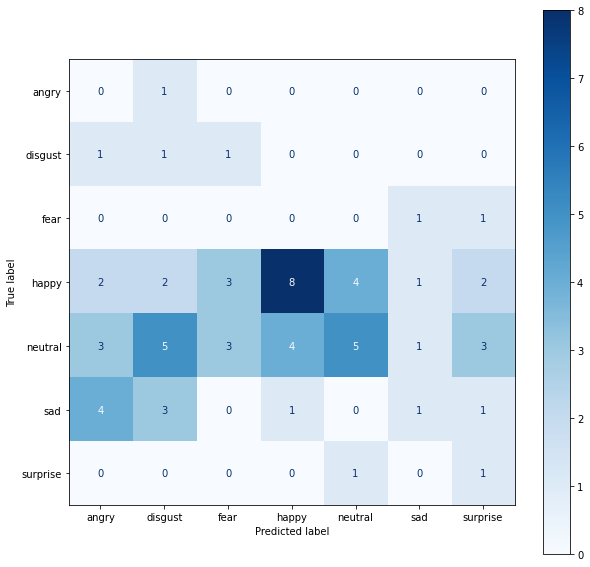

In [80]:
plot_confusion_matrix(labels, y_preds, class_names)

### Classification report

In [81]:
from sklearn.metrics import classification_report

In [82]:
cr = classification_report(labels, y_preds, output_dict=False, labels=labels, target_names =[class_names[i] for i in labels])
print(cr)

              precision    recall  f1-score   support

         sad       0.25      0.10      0.14        10
         sad       0.25      0.10      0.14        10
       happy       0.62      0.36      0.46        22
     neutral       0.50      0.21      0.29        24
         sad       0.25      0.10      0.14        10
       happy       0.62      0.36      0.46        22
     neutral       0.50      0.21      0.29        24
     neutral       0.50      0.21      0.29        24
     neutral       0.50      0.21      0.29        24
         sad       0.25      0.10      0.14        10
     neutral       0.50      0.21      0.29        24
     neutral       0.50      0.21      0.29        24
     neutral       0.50      0.21      0.29        24
       happy       0.62      0.36      0.46        22
       happy       0.62      0.36      0.46        22
     neutral       0.50      0.21      0.29        24
         sad       0.25      0.10      0.14        10
         sad       0.25    